# 04 - Optimal number of seasons: *Silhouette score*

In [71]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping

import os

from models.X_RCC import XRCC, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

In [72]:
# -- FREE PARAMETERS
n_iters     = 50

learning_rate   = 2
min_len         = 30
mode            = 'single'
starting_bp     = [165, 264]

subscribe_results = False

In [73]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Path for results
results_path_file   = f'../data/results/netcdf_files/silhouette_results_seas_{n_iters}iters.nc'
results_path_image_sil  = f'../data/results/images/silhouette_results_seas_{n_iters}iters.png'
results_path_image_best  = f'../data/results/images/silhouette_results_seas_{n_iters}iters_best.png'

if os.path.exists(results_path_file) and subscribe_results:
    results_exist = True
    print('Results already stored! - Overwriting')

if os.path.exists(results_path_file) and not subscribe_results:
    results_exist = True
    print('Results already stored! - Skipping clustering')

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

In [74]:
if not os.path.exists(results_path_file) or subscribe_results:

    dataset_t2m = xr.open_mfdataset(rf'/work/users/jgrassi/Radially_constrained_clustering/data/India/ERA5/preprocessed/2m_temperature/temperature_1980_2011_15dd.nc').var167.load()
    dataset_tp = xr.open_mfdataset(rf'/work/users/jgrassi/Radially_constrained_clustering/data/India/ERA5/preprocessed/total_precipitation/precipitation_1980_2011_15dd.nc').tp.load()

    dataset_tp['time'] = dataset_t2m['time']

    datasets = [dataset_tp, dataset_t2m]  # Add as many datasets as needed

    tot = []
    for j, st in zip([2,4], [[165, 264],[80, 165, 264, 300]]):
        clustering_params = {
            'iters': n_iters,
            'learning_rate': learning_rate,
            'min_len': min_len,
            'mode': mode,
            'starting_bp': st,  # Optional, if starting_bp is used
            'n_seas' : j
        }

        silhouette_scores = XRCC_silhouette(datasets, **clustering_params)
        tot.append(silhouette_scores.assign_coords(n_seasons=j))

    result = xr.concat(tot, dim='n_seasons')


    combined_data_array_filled = result.fillna(-np.inf)
    max_n_seasons_idx = combined_data_array_filled.argmax(dim='n_seasons')
    max_n_seasons = result['n_seasons'][max_n_seasons_idx]

    # Crea una lista di maschere per ciascun n_seasons
    nan_masks = [np.isnan(result.sel(n_seasons=season)) for season in [2,4]]

    # Usa np.logical_and.reduce per combinare tutte le maschere
    combined_nan_mask = np.logical_and.reduce(nan_masks)

    # Rimuovere i NaN dai risultati finali usando il mask
    max_n_seasons = max_n_seasons.where(~combined_nan_mask)

    result = xr.merge([result.rename('silhouette_score'), max_n_seasons.rename('optimal_n_seasons')])


else:
    result = xr.open_dataset(results_path_file)


In [75]:
if not os.path.exists(results_path_file) or subscribe_results:
    
    result.attrs=dict(
            Description="Dataset with silhouette scores obtained with Radially Constrained Clustering",
            Parameters=(
                f"Number of iterations: {n_iters}",
                f"Learning rate: {learning_rate}",
                f"Minimum length of seasons: {min_len}",
                f"Clustering mode: {mode}",
        
            )
        )

    result.to_netcdf(results_path_file)

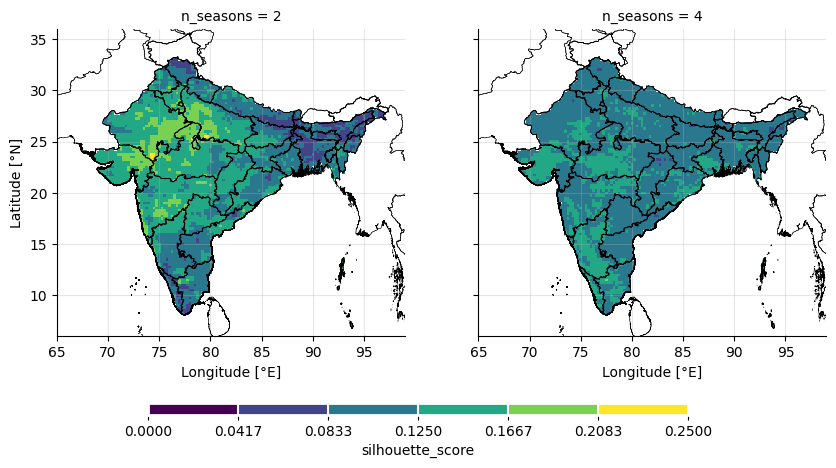

In [80]:
# Load country boundary data
mask_boundary = gpd.read_file(world_boundary_file, layer='ADM_1')
mask_boundary = mask_boundary[mask_boundary["GID_0"].isin(['IND','NPL','BGD',])]

result_plot = result.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
result_plot.rio.write_crs("epsg:4326", inplace=True)
result_plot = result_plot.rio.clip(mask_boundary.geometry.apply(mapping), mask_boundary.crs, drop=True)


plot = result_plot.silhouette_score.plot(col='n_seasons', col_wrap=2, vmin=0, vmax=0.25, levels=7, add_colorbar=False, figsize=(9,4))

standard_format( plot,
                 country_boundary   = country_boundary,
                 world_boundary     = world_boundary,
                 custom_cbar        = True
                )

plt.savefig(results_path_image_sil, dpi=300, bbox_inches='tight', transparent=False)

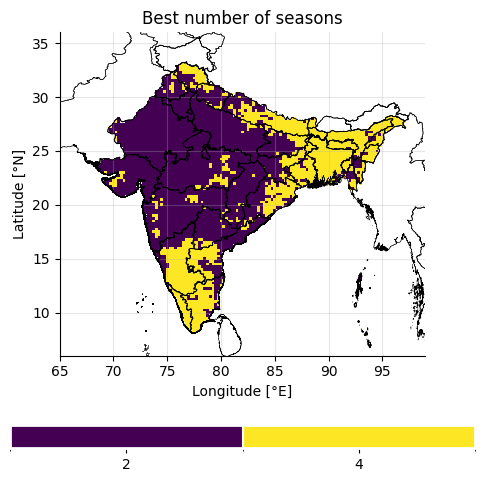

In [81]:
plot = result_plot.optimal_n_seasons.plot(vmin=1, vmax=5, levels=3, add_colorbar=False, figsize=(6,6))

standard_format_single( plot,
                 country_boundary   = country_boundary,
                 world_boundary     = world_boundary,
                 custom_cbar        = True
                )

plot.colorbar.set_ticks(ticks=[2,4], labels=[2,4])
plot.axes.set_title('Best number of seasons')

plt.savefig(results_path_image_best, dpi=300, bbox_inches='tight', transparent=False)